### Setup and Helper Functions
In this cell, we import all necessary libraries and define helper functions that will be used throughout the notebook. These functions include feature extraction, data processing, model training, and visualization utilities.


In [1]:
# Import necessary libraries
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Atom types and labels
atom_types = [1, 6, 7, 8, 16]  # H, C, N, O, S
atom_labels = ['H', 'C', 'N', 'O', 'S']

# Helper functions
def phi(atomic_number):
    return [1 if atomic_number == at else 0 for at in atom_types]

def build_feature_vector_with_positions(Z, R, max_atoms=23):
    n_features_per_atom = len(atom_types) + 3  # one-hot encoding + 3D coordinates
    padded_length = max_atoms * n_features_per_atom
    feature_vectors = []
    for i in range(len(Z)):
        molecule = Z[i]
        coords = R[i]
        feature_vector = []
        for atom, coord in zip(molecule, coords):
            if atom > 0:
                feature_vector.extend(phi(atom) + list(coord))
        # Pad the feature vector to the fixed length
        feature_vector.extend([0] * (padded_length - len(feature_vector)))
        feature_vectors.append(feature_vector)
    return np.array(feature_vectors)

def closed_form_ridge(X, y, lambda_):
    n, d = X.shape
    I = np.identity(d)
    w = np.linalg.inv(X.T @ X + lambda_ * I) @ (X.T @ y)
    return w

def compute_contributions(molecule, w, R, max_atoms=23):
    n_features_per_atom = len(atom_types) + 3  # one-hot encoding + 3D coordinates
    padded_length = max_atoms * n_features_per_atom
    contributions = []
    for atom, coord in zip(molecule, R):
        if atom > 0:
            feature = phi(atom) + list(coord)
            feature.extend([0] * (padded_length - len(feature)))
            contribution = np.dot(w, feature)
            contributions.append(contribution)
        else:
            contributions.append(0)
    return np.array(contributions)

def visualize_contributions(molecule_index, Z, R, w_best, max_atoms=23):
    molecule = Z[molecule_index]
    coords = R[molecule_index]
    contributions = compute_contributions(molecule, w_best, coords, max_atoms)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    colors = ['blue', 'black', 'red', 'green', 'yellow']
    
    for i in range(len(molecule)):
        if molecule[i] > 0:
            atom_type = molecule[i]
            ax.scatter(coords[i, 0], coords[i, 1], coords[i, 2], 
                       color=colors[atom_types.index(atom_type)], 
                       s=100, label=f'{atom_labels[atom_types.index(atom_type)]}: {contributions[i]:.2f}')
            ax.text(coords[i, 0], coords[i, 1], coords[i, 2], f'{contributions[i]:.2f}', color='black')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title(f'Contributions of Atoms in Molecule {molecule_index}')
    plt.show()

def phi_combined(atom1, atom2, distance, thresholds):
    phi_a = phi_distances(distance, thresholds)
    phi_b = phi_atom_types(atom1, atom2)
    return np.outer(phi_a, phi_b).flatten()

def phi_distances(distance, thresholds):
    return [1 if thresholds[i] <= distance < thresholds[i + 1] else 0 for i in range(len(thresholds) - 1)]

def phi_atom_types(atom1, atom2):
    atom_pairs = [(1, 1), (1, 6), (1, 7), (1, 8), (1, 16),
                  (6, 6), (6, 7), (6, 8), (6, 16),
                  (7, 7), (7, 8), (7, 16),
                  (8, 8), (8, 16),
                  (16, 16)]
    atom_pair = tuple(sorted((atom1, atom2)))
    return [1 if atom_pair == pair else 0 for pair in atom_pairs]


### Task 1: Data Loading
In this task, we load the QM7 dataset and extract the relevant variables: 3D coordinates of atoms, atomic numbers, and atomization energies.


In [2]:
# Load the QM7 dataset
data = scipy.io.loadmat('./qm7.mat')

# Extract variables
R = data['R']  # 3D coordinates of atoms
Z = data['Z']  # Atomic numbers
T = data['T']  # Atomization energies


We have successfully loaded the dataset and extracted the variables `R`, `Z`, and `T` for further processing.


### Task 1: Preprocessing for Atom-based Representation
Prepare the data for ridge regression model using atom-based feature vectors. We will build feature vectors for all molecules and center the data.


Feature vectors for first 5 molecules:
 [[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.88643801e+00 -4.64872643e-03 -8.23920593e-03
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  3.94992447e+00 -4.59203450e-03  7.82346632e-03
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.19768953e+00  1.94048417e+00  7.82346632e-03
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.18493390e+00 -9.97265160e-01  1.65938747e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.21199477e+00 -9.58979309e-01 -1.71095800e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0

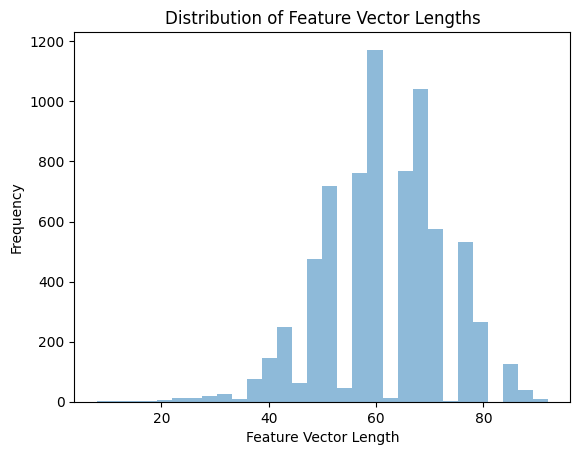

In [3]:
# Build feature vectors for all molecules including positions
X = build_feature_vector_with_positions(Z, R)
y = T.ravel()  # Flatten T to a 1D array

# Debugging: Check the feature vectors
print("Feature vectors for first 5 molecules:\n", X[:5])
print("Unique feature vectors:\n", np.unique(X, axis=0))

# Plotting the distribution of feature vectors lengths to understand the padding
feature_lengths = [len([v for v in vector if v != 0]) for vector in X]
plt.hist(feature_lengths, bins=30, alpha=0.5)
plt.xlabel('Feature Vector Length')
plt.ylabel('Frequency')
plt.title('Distribution of Feature Vector Lengths')
plt.show()

# Center the data
X_mean = np.mean(X, axis=0)
y_mean = np.mean(y)
X_centered = X - X_mean
y_centered = y - y_mean

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_centered, y_centered, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


We have built the feature vectors, centered the data, and split it into training and testing sets.


### Task 1: Standardizing Features
Standardize the features for better performance of the ridge regression model.


In [4]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


We have standardized the training and testing features.


### Task 1: Training Ridge Regression Model (Atom-based)
Train a ridge regression model using the atom-based feature vectors and evaluate its performance.


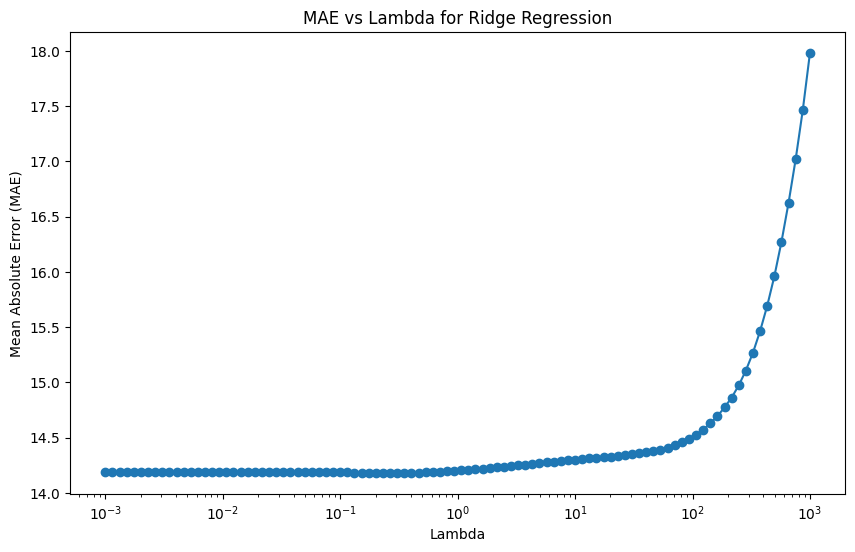

Best Lambda: 0.30538555088334157
Mean Absolute Error: 14.178318574812584 kcal/mol
R^2 Score: 0.9932158090534867


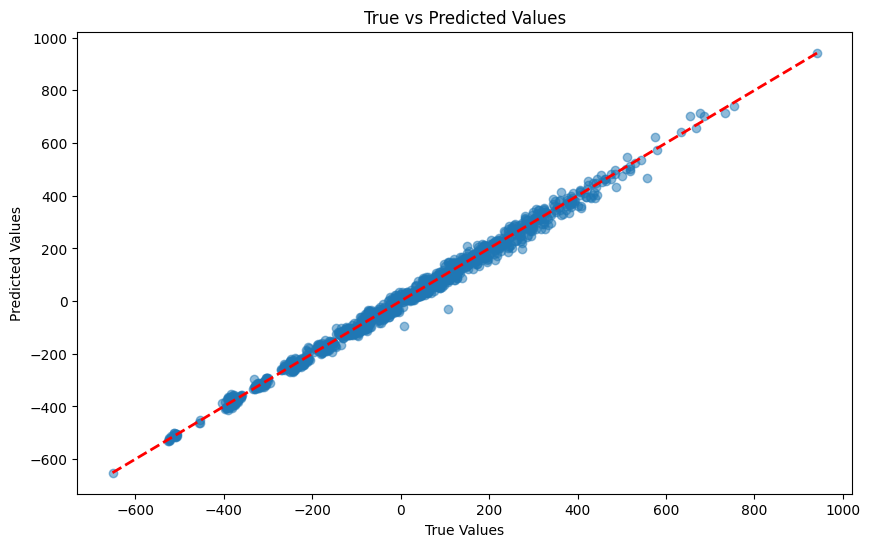

Weights (w_best):
[ 0.00000000e+00 -1.20518375e+01  7.35243709e+00  8.44132929e+00
  6.08301570e-01  1.60580842e+00  3.31889901e+00  4.99790807e-01
  5.01344530e-01 -1.35033451e+01  8.92793004e+00  8.23137073e+00
  4.94392072e+00 -1.58236621e+00 -3.32831173e+00 -5.19655456e-01
  1.57796037e+00 -1.24747927e+01  8.18411906e+00  7.52653640e+00
  4.43864136e+00 -5.60573399e-01  1.59940382e+00 -5.73409695e-01
  1.87644771e+00 -1.38241169e+01  8.53671728e+00  8.17289322e+00
  5.11105616e+00  1.33466268e+00 -2.83141804e+00  3.30169092e-01
 -6.10326019e+00 -6.63443188e+01 -3.16318344e+01 -3.08312098e+01
 -7.54813187e+00 -3.80578225e+00  3.14442836e-01 -5.32179084e-01
 -1.11866312e+01 -6.79747745e+01 -3.44546338e+01 -2.81631199e+01
 -2.91395818e+00 -6.52629267e-01  2.88026025e+00 -2.98565822e-01
 -2.71640271e+01 -8.36482532e+01 -4.68370295e+01 -5.09474600e+01
 -1.21147932e+01  6.31547511e+00  1.86363359e+00 -7.33495736e-01
 -3.05258015e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.000

In [5]:
# Train and evaluate the ridge regression model using atom-based representation
lambdas = np.logspace(-3, 3, 100)
best_lambda = None
best_score = float('inf')
mae_scores = []

for lambda_ in lambdas:
    w = closed_form_ridge(X_train_scaled, y_train, lambda_)
    y_pred = X_test_scaled @ w
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)
    if mae < best_score:
        best_score = mae
        best_lambda = lambda_

# Plotting the MAE against lambda values
plt.figure(figsize=(10, 6))
plt.plot(lambdas, mae_scores, marker='o')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE vs Lambda for Ridge Regression')
plt.show()

# Train the model with the best lambda
w_best = closed_form_ridge(X_train_scaled, y_train, best_lambda)

# Predict on the test set
y_pred = X_test_scaled @ w_best

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Best Lambda: {best_lambda}")
print(f"Mean Absolute Error: {mae} kcal/mol")
print(f"R^2 Score: {r2}")

# Plotting the true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()

# Debugging: Check the weights
print(f"Weights (w_best):\n{w_best}")


We have trained the ridge regression model using the atom-based feature vectors. The best regularization parameter `lambda` was selected using cross-validation. The model's performance is evaluated using Mean Absolute Error (MAE) and R-squared (R²) score.


### Task 2: Visualization of Atom-based Contributions
Visualize the contributions of different atoms within a molecule.


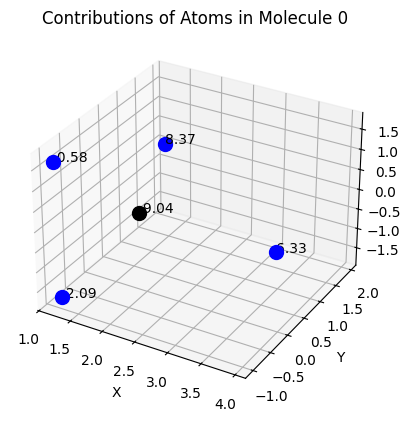

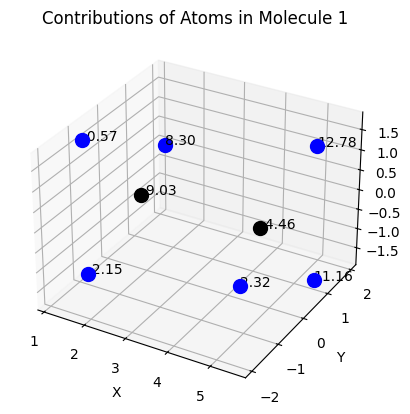

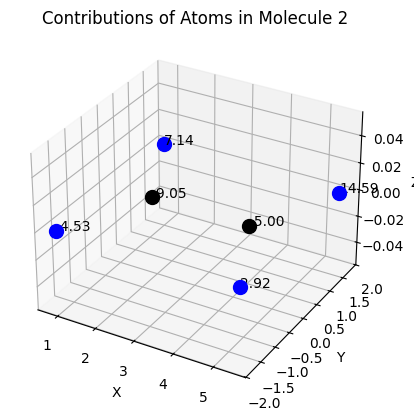

In [6]:
# Visualize contributions for a few molecules
for i in range(3):  # Visualize the first 3 molecules for example
    visualize_contributions(i, Z, R, w_best)


We have visualized the contributions of different atoms within a few molecules using the trained ridge regression model.


### Task 2: Summarizing Atom-based Contributions
Summarize the contributions of different atom types across all molecules.


Contributions for atom type H: [6.331491568446425, 8.367441002873084, -0.5776989109446444, -2.0916451527423243, 8.299294435570323]... (showing first 5 contributions)
Contributions for atom type C: [-9.042125956467679, -9.02958614092624, -4.46053139654068, -9.049566584946108, -4.997845111612792]... (showing first 5 contributions)
Contributions for atom type N: [7.054397381987268, 25.24224409603023, 18.261632036161295, 14.911463562878488, 0.23672907169955604]... (showing first 5 contributions)
Contributions for atom type O: [25.95234804336345, 24.29092615414775, 15.882437585865205, 8.246802342490364, 1.6617101537206524]... (showing first 5 contributions)
Contributions for atom type S: [-8.930688738423846, -7.897148666396429, -9.667039514517517, 1.2705687458528896, 2.2009769736207954]... (showing first 5 contributions)


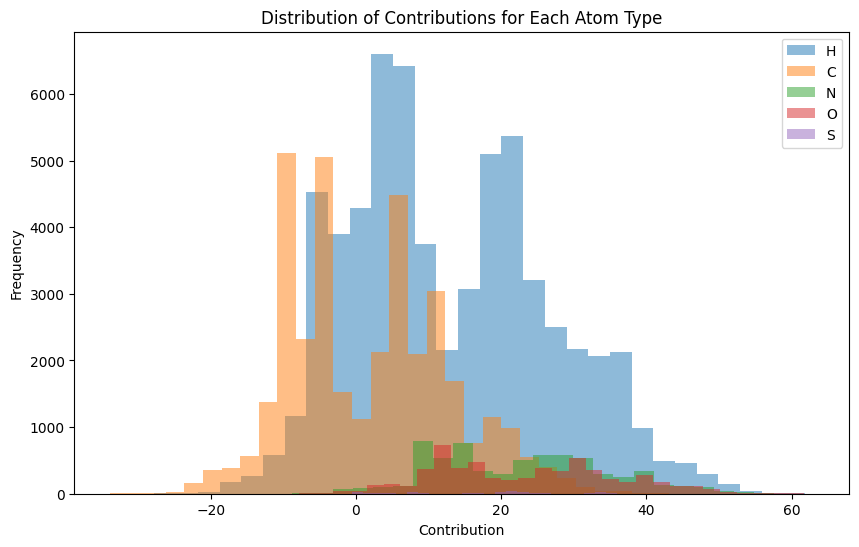

In [7]:
# Summarize contributions across all molecules for each atom type
def summarize_contributions(Z, R, w):
    contributions_summary = {atom: [] for atom in atom_labels}
    
    for i in range(len(Z)):
        molecule = Z[i]
        coords = R[i]
        for atom, coord in zip(molecule, coords):
            if atom > 0:
                feature = phi(atom) + list(coord)
                n_features_per_atom = len(atom_types) + 3  # one-hot encoding + 3D coordinates
                padded_length = 23 * n_features_per_atom
                feature.extend([0] * (padded_length - len(feature)))
                contribution = np.dot(w, feature)
                atom_label = atom_labels[atom_types.index(atom)]
                contributions_summary[atom_label].append(contribution)
    
    return contributions_summary

contributions_summary = summarize_contributions(Z, R, w_best)

# Debugging: Check if contributions_summary is populated correctly
for atom_label, contributions in contributions_summary.items():
    if not contributions:
        print(f"No contributions found for atom type: {atom_label}")
    else:
        print(f"Contributions for atom type {atom_label}: {contributions[:5]}... (showing first 5 contributions)")

# Plot contributions summary
plt.figure(figsize=(10, 6))
for atom_label, contributions in contributions_summary.items():
    if contributions:  # Check if there are contributions for this atom type
        plt.hist(contributions, bins=30, alpha=0.5, label=atom_label)
    else:
        print(f"Skipping atom type: {atom_label} due to no contributions")

plt.xlabel('Contribution')
plt.ylabel('Frequency')
plt.title('Distribution of Contributions for Each Atom Type')
plt.legend()
plt.show()


We have summarized and visualized the contributions of different atom types across all molecules.


### Task 3: Preprocessing for Pair-based Representation
Decompose each molecule into pairs of atoms and generate a feature representation that includes both distances and atom types.


In [8]:
# Define distance thresholds for one-hot encoding of distances
thresholds = np.linspace(0, 5, 10)  # Adjust thresholds as needed

# Build feature vectors for all molecules based on pairs of atoms
def build_feature_vector_pairs(Z, R, thresholds):
    feature_vectors = []
    for molecule_idx in range(Z.shape[0]):
        molecule = Z[molecule_idx]
        coords = R[molecule_idx]
        n_atoms = np.sum(molecule > 0)
        feature_vector = np.sum(
            [phi_combined(molecule[i], molecule[j], np.linalg.norm(coords[i] - coords[j]), thresholds)
             for i in range(n_atoms) for j in range(i + 1, n_atoms)], axis=0)
        feature_vectors.append(feature_vector)
    return np.array(feature_vectors)

X_pairs = build_feature_vector_pairs(Z, R, thresholds)
y = T.ravel()  # Flatten T to a 1D array

# Center the data
X_mean = np.mean(X_pairs, axis=0)
y_mean = np.mean(y)
X_centered = X_pairs - X_mean
y_centered = y - y_mean

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_centered, y_centered, test_size=0.2, random_state=42)


We have decomposed each molecule into pairs of atoms, generated the pair-based feature vectors, centered the data, and split it into training and testing sets.


### Task 3: Standardizing Pair-based Features
Standardize the features for better performance of the ridge regression model.


In [9]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


We have standardized the training and testing features.


### Task 3: Training Ridge Regression Model (Pair-based)
Train a ridge regression model using the pair-based feature vectors and evaluate its performance.


In [10]:
# Train and evaluate the ridge regression model using pair-based representation
best_lambda = None
best_score = float('inf')

for lambda_ in lambdas:
    w = closed_form_ridge(X_train_scaled, y_train, lambda_)
    y_pred = X_test_scaled @ w
    mae = mean_absolute_error(y_test, y_pred)
    if mae < best_score:
        best_score = mae
        best_lambda = lambda_

# Train the model with the best lambda
w_best = closed_form_ridge(X_train_scaled, y_train, best_lambda)

# Predict on the test set
y_pred = X_test_scaled @ w_best

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Best Lambda: {best_lambda}")
print(f"Mean Absolute Error: {mae} kcal/mol")
print(f"R^2 Score: {r2}")


Best Lambda: 0.001
Mean Absolute Error: 23.862317495533397 kcal/mol
R^2 Score: 0.9814396544253653


We have trained the ridge regression model using the pair-based feature vectors. The best regularization parameter `lambda` was selected using cross-validation. The model's performance is evaluated using Mean Absolute Error (MAE) and R-squared (R²) score.


### Task 3: Analysis of Pairwise Potentials
Analyze pairwise potentials by plotting the contributions of pairs of atoms as a function of their distance.


Skipping atom pair: (16, 16) due to no contributions


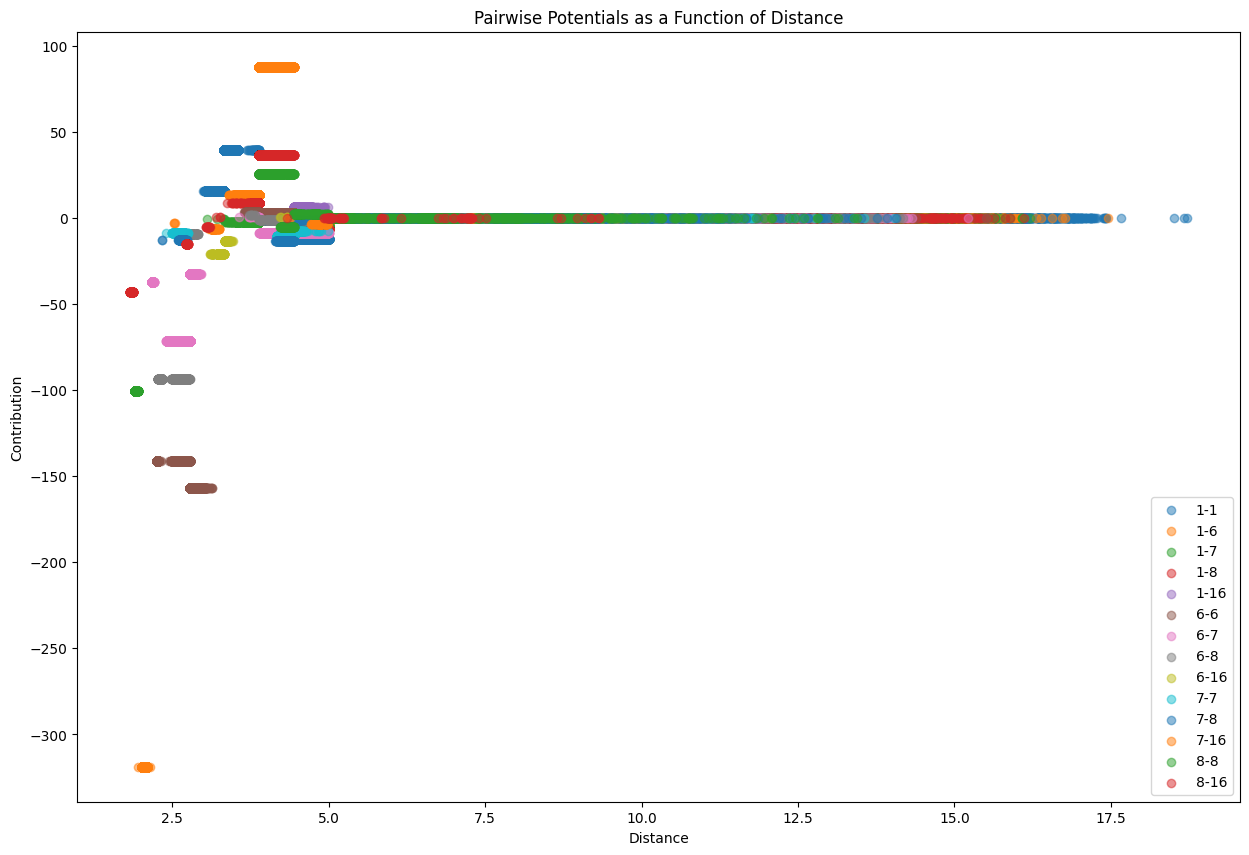

In [11]:
# Analyze pairwise potentials
def compute_contributions_pairs(Z, R, w, thresholds):
    contributions_summary = {pair: [] for pair in [(1, 1), (1, 6), (1, 7), (1, 8), (1, 16),
                                                   (6, 6), (6, 7), (6, 8), (6, 16),
                                                   (7, 7), (7, 8), (7, 16),
                                                   (8, 8), (8, 16),
                                                   (16, 16)]}
    for molecule_idx in range(Z.shape[0]):
        molecule = Z[molecule_idx]
        coords = R[molecule_idx]
        n_atoms = np.sum(molecule > 0)
        for i in range(n_atoms):
            for j in range(i + 1, n_atoms):
                atom1, atom2 = molecule[i], molecule[j]
                distance = np.linalg.norm(coords[i] - coords[j])
                feature_vector = phi_combined(atom1, atom2, distance, thresholds)
                contribution = np.dot(w, feature_vector)
                atom_pair = tuple(sorted((atom1, atom2)))
                contributions_summary[atom_pair].append((distance, contribution))
    return contributions_summary

contributions_pairs = compute_contributions_pairs(Z, R, w_best, thresholds)

# Plot pairwise potentials as a function of distance for each pair of atom types
atom_pairs = [(1, 1), (1, 6), (1, 7), (1, 8), (1, 16),
              (6, 6), (6, 7), (6, 8), (6, 16),
              (7, 7), (7, 8), (7, 16),
              (8, 8), (8, 16),
              (16, 16)]

plt.figure(figsize=(15, 10))
for atom_pair in atom_pairs:
    if contributions_pairs[atom_pair]:  # Check if there are contributions for this pair
        distances, contributions = zip(*contributions_pairs[atom_pair])
        plt.scatter(distances, contributions, alpha=0.5, label=f'{atom_pair[0]}-{atom_pair[1]}')
    else:
        print(f"Skipping atom pair: {atom_pair} due to no contributions")

plt.xlabel('Distance')
plt.ylabel('Contribution')
plt.title('Pairwise Potentials as a Function of Distance')
plt.legend()
plt.show()


We have analyzed and visualized the pairwise potentials by plotting the contributions of pairs of atoms as a function of their distance.
